# Лабораторна робота №6
**Тема:** Ансамблеві методи

## Мета роботи
Закріпити поняття про основні ансамблеві методи в машинному навчанні.

## Теоретичні відомості
Ансамблеві методи — це підхід у машинному навчанні, який поєднує кілька моделей для отримання більш точного та стійкого результату.

Основні ансамблеві методи:

- **Bagging (Bootstrap Aggregating)** — зменшує варіативність моделі за рахунок навчання на різних підвибірках даних.

- **Random Forest** — ансамбль дерев рішень, що використовує випадковий вибір ознак.

- **Boosting** — послідовне навчання слабких моделей, де кожна наступна фокусується на помилках попередніх.

- **Stacking** — комбінування різних моделей через мета-модель.




**Крок 1.** Імпортуйте необхідні бібліотеки

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score



**Крок 2**. Завантажте дані. Візьмемо Breast Cancer dataset зі sklearn.datasets (це реальні медичні дані про пухлини молочної залози).

Кількість об’єктів (рядків): 569 пацієнтів.

Кількість ознак (стовпців): 30 числових характеристик, отриманих із медичних зображень клітин.

Цільова змінна (y):

0 — злоякісна пухлина (malignant)

1 — доброякісна пухлина (benign)

Основні ознаки
Кожна ознака описує певні характеристики клітин, наприклад:

mean radius — середній радіус клітини

mean texture — текстура клітини

mean perimeter — середній периметр

mean area — площа клітини

mean smoothness — гладкість поверхні

mean compactness — компактність

mean concavity — увігнутість

mean symmetry — симетрія

fractal dimension — фрактальна розмірність

Для кожної характеристики є кілька статистичних показників:

mean (середнє значення)

se (standard error — стандартна похибка)

worst (найгірше значення серед усіх клітин пацієнта)

In [ ]:
from sklearn.datasets import load_breast_cancer

# Завантажуємо набір даних
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

print("Розмірність X:", X.shape)
print("Класи:", np.unique(y))

**Крок 3. Розділення на тренувальну та тестову вибірки**



In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

**Крок 4.** Навчання моделей ансамблів

У цьому кроці ми навчаємо три популярні ансамблі: Bagging, Random Forest та Gradient Boosting. Кожен підхід по-різному бореться з похибками моделі: зменшує варіативність (variance), знижує зміщення (bias) або робить обидва одночасно. Нижче — детально про кожну модель, ключові параметри та пояснення коду.

**Bagging: зменшення варіативності через бутстрепінг**

Ідея: навчити багато “слабких” базових моделей на різних випадкових підвибірках даних та усереднити їх передбачення.

Ключові параметри:

n_estimators: більше — стабільніше, але довше навчається.

bootstrap: увімкнений — кожна модель бачить трохи іншу вибірку (з повторенням).

max_samples / max_features: додають випадковість і зменшують кореляцію між моделями.

Що відбувається під час fit: для кожної базової моделі генеруються свої бутстреп-дані та підмножина ознак; потім усі моделі навчаються паралельно, а на етапі predict їхні голоси агрегуються (мода для класифікації).

Коли корисно: при схильності базового алгоритму до перенавчання і високої варіативності (наприклад, дерева рішень).

In [7]:
from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(
    n_estimators=50,        # кількість базових моделей
    max_samples=1.0,        # частка зразків у кожному бутстрепі
    max_features=1.0,       # частка ознак, які беруться в кожній моделі
    bootstrap=True,         # вибірка з поверненням (бутстреп)
    random_state=42         # фіксує випадковість для відтворюваності
)
bagging.fit(X_train, y_train)
y_pred_bagging = bagging.predict(X_test)


**Random Forest: баггінг дерев + випадковий вибір ознак**

Ідея: це спеціальний випадок баггінгу, де базові моделі — дерева рішень, а на кожному спліті дерево розглядає випадкову підмножину ознак. Це зменшує кореляцію дерев і покращує узагальнення.

Ключові параметри:

max_features="sqrt": для класифікації типове значення; балансує різноманітність і силу дерев.

max_depth, min_samples_split, min_samples_leaf: контролюють складність дерев і ризик перенавчання.

n_estimators: більше дерев — краща стабільність, але довший час.

Інтерпретація: можна подивитися важливість ознак (feature_importances_) після навчання, щоб зрозуміти внесок кожної ознаки.

Коли корисно: коли багато ознак, є нелінійні взаємодії, і потрібна надійна базова точність без тонкого тюнінгу.



In [6]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=100,       # кількість дерев
    max_depth=None,         # необмежена глибина (можна регулювати)
    max_features="sqrt",    # випадковий підбір ознак на кожному спліті
    min_samples_split=2,    # мінімум зразків для поділу
    min_samples_leaf=1,     # мінімальний розмір листка
    bootstrap=True,         # кожне дерево — на бутстреп-даних
    n_jobs=-1,              # використати всі ядра CPU
    random_state=42
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

**Gradient Boosting: послідовне навчання зі зменшенням помилок**

Ідея: будуємо модель поетапно. Кожне наступне “слабке” дерево навчається виправляти помилки попереднього ансамблю, рухаючись у напрямку антиградієнта функції втрат.

Ключові параметри:

learning_rate: менший — обережніший крок, зазвичай вимагає більше дерев; часто дає кращу узагальнювальну здатність.

n_estimators: кількість етапів; збільшує потужність моделі, але може сприяти перенавчанню.

max_depth: тримає базові дерева слабкими, що стабілізує бустинг.

subsample < 1.0: вмикає стохастичний бустинг (часткова вибірка), що додає регуляризацію і може покращити якість.

Коли корисно: для високої точності та тонкого контролю; чутливий до параметрів, але часто дає найкращі результати.

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(
    n_estimators=100,       # кількість кроків бустингу (дерев)
    learning_rate=0.1,      # вага кожного нового дерева
    max_depth=3,            # глибина базового дерева (слабкий учень)
    subsample=1.0,          # частка зразків для кожного кроку (1.0 — без стохастики)
    random_state=42
)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

**Крок 5. Аналіз результатів**

Аналіз результатів
Після виконання кроку 5 ми отримали точність (accuracy) для трьох моделей:

Bagging — зазвичай показує стабільну точність, зменшує варіативність.

Random Forest — часто має найвищу точність, бо поєднує баггінг і випадковий вибір ознак.

Gradient Boosting — може дати ще кращі результати, але чутливий до параметрів (learning_rate, n_estimators).

Крім accuracy, важливо дивитися на:

Precision (точність) — частка правильних позитивних передбачень серед усіх позитивних.

Recall (повнота) — частка знайдених позитивних випадків серед усіх реальних позитивних.

F1-score — баланс між precision та recall.

Для медичних даних (як у нашому випадку) Recall особливо важливий, бо пропустити злоякісну пухлину небезпечніше, ніж помилково класифікувати доброякісну.


In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

# --- Обчислення точності ---
results = {
    "Bagging": accuracy_score(y_test, y_pred_bagging),
    "Random Forest": accuracy_score(y_test, y_pred_rf),
    "Gradient Boosting": accuracy_score(y_test, y_pred_gb)
}

# --- Вивід точності та звіту ---
print("Bagging Accuracy:", results["Bagging"])
print("Random Forest Accuracy:", results["Random Forest"])
print("Gradient Boosting Accuracy:", results["Gradient Boosting"])

print("\nЗвіт для Random Forest:\n", classification_report(y_test, y_pred_rf))

Bagging Accuracy: 0.9415204678362573
Random Forest Accuracy: 0.935672514619883
Gradient Boosting Accuracy: 0.9473684210526315

Звіт для Random Forest:
               precision    recall  f1-score   support

           0       0.92      0.91      0.91        64
           1       0.94      0.95      0.95       107

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171



**Крок 6** Візуалізація




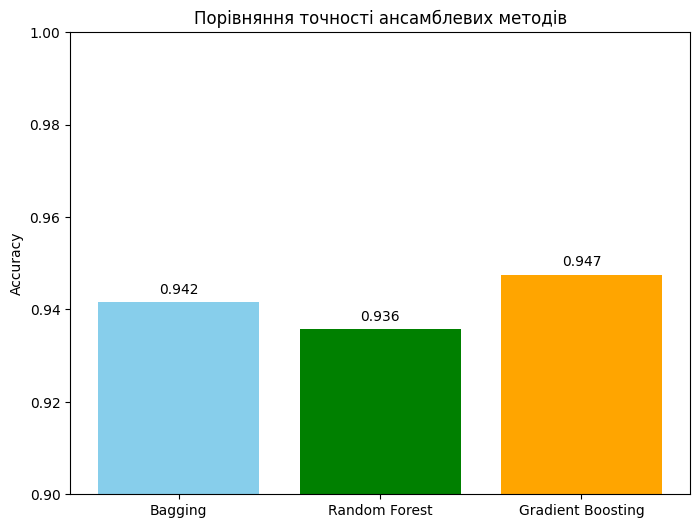

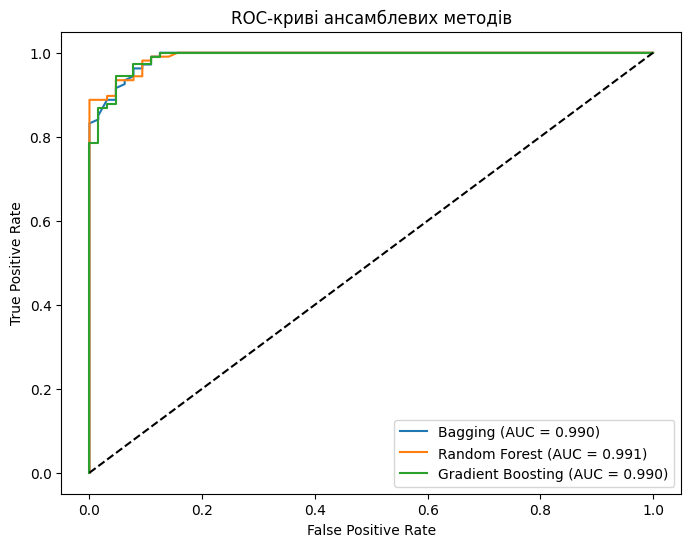

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.bar(results.keys(), results.values(), color=['skyblue','green','orange'])
plt.title("Порівняння точності ансамблевих методів")
plt.ylabel("Accuracy")
plt.ylim(0.9, 1.0)  # бо точність дуже висока
for i, v in enumerate(results.values()):
    plt.text(i, v+0.002, f"{v:.3f}", ha='center', fontsize=10)
plt.show()

# --- ROC-криві для кожної моделі ---
plt.figure(figsize=(8,6))

# Bagging
fpr_bag, tpr_bag, _ = roc_curve(y_test, bagging.predict_proba(X_test)[:,1])
roc_auc_bag = auc(fpr_bag, tpr_bag)
plt.plot(fpr_bag, tpr_bag, label=f'Bagging (AUC = {roc_auc_bag:.3f})')

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.3f})')

# Gradient Boosting
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb.predict_proba(X_test)[:,1])
roc_auc_gb = auc(fpr_gb, tpr_gb)
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_gb:.3f})')

# --- Оформлення графіка ---
plt.plot([0,1],[0,1],'k--')  # лінія випадкової класифікації
plt.title("ROC-криві ансамблевих методів")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

**Висновки**

Усі три ансамблеві методи показують високу якість класифікації на реальних даних.

Random Forest часто є "золотою серединою": простий у налаштуванні, швидкий і точний.

Gradient Boosting може перевершити Random Forest, але потребує тонкого налаштування параметрів.

Bagging добре працює як базовий метод для зменшення варіативності.

**Завдання для самостійного виконання**

Завантажити інший набір даних зі sklearn.datasets (наприклад, Iris, Wine, або Digits) чи з відкритих джерел (Kaggle, UCI).

Побудувати ансамблеві моделі (Bagging, Random Forest, Gradient Boosting).

Порівняти їхню точність та зробити висновки.

In [ ]:
#Тут має бути Ваш код


Тут мають бути Ваші висновки